In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [2]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [3]:
print("X shape: ",X.shape)
print("y shape: ",y.shape)

X shape:  (70000, 784)
y shape:  (70000,)


There are 70,000 images, and each image has 784 features. This is because
each image is 28 × 28 pixels, and each feature simply represents one pixel’s
intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from
the dataset.

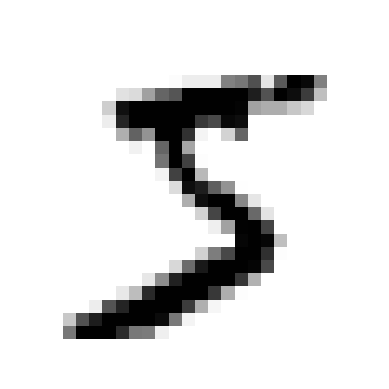

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
# save_fig("some_digit_plot")  # extra code
plt.show()

# The Data
The MNIST dataset returned by
fetch_openml() is actually already split into a training set (the first
60,000 images) and a test set (the last 10,000 images). The training set is already shuffled for us

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier

In [6]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [8]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

## Confusion Matrix

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

## Precision and Recall

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train_5, y_train_pred) 

0.9570333333333333

In [13]:
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [14]:
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [15]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

Now your 5-detector does not look as shiny as it did when you looked at its
accuracy. When it claims an image represents a 5, it is correct only 83.7%
of the time. Moreover, it only detects 65.1% of the 5s.

## Precision/Recall Trade-off

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Suppose you decide to aim for 90% precision

In [18]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [19]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_at_90_precision = precision_score(y_train_5, y_train_pred_90)
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

print("precision_at_90_precision: ",precision_at_90_precision ,"recall_at_90_precision: ",recall_at_90_precision )

precision_at_90_precision:  0.9000345901072293 recall_at_90_precision:  0.4799852425751706


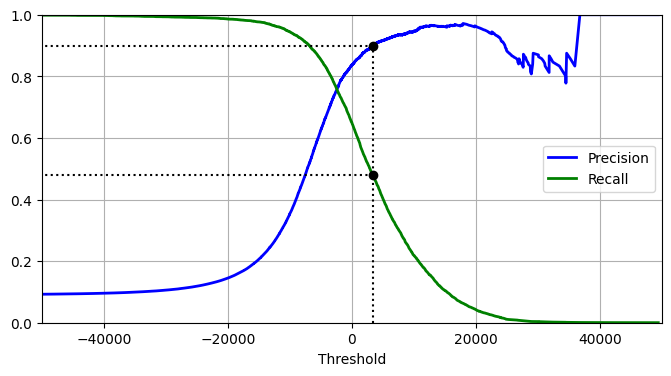

In [20]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.plot(thresholds[idx_for_90_precision], precisions[idx_for_90_precision], 'ko')
plt.plot(thresholds[idx_for_90_precision], recalls[idx_for_90_precision], 'ko')

plt.plot([thresholds[idx_for_90_precision], thresholds[idx_for_90_precision]], [0., precisions[idx_for_90_precision]], "k:")
plt.plot([thresholds[idx_for_90_precision], thresholds[0]], [precisions[idx_for_90_precision], precisions[idx_for_90_precision]], "k:")
plt.plot([thresholds[idx_for_90_precision], thresholds[0]], [recalls[idx_for_90_precision], recalls[idx_for_90_precision]], "k:")

# extra code – just beautifies
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

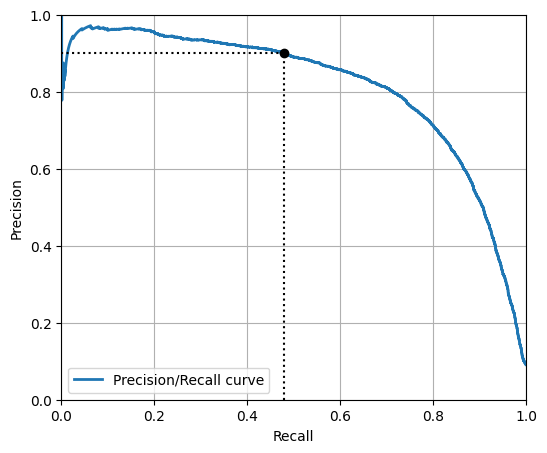

In [21]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot(recalls[idx_for_90_precision], precisions[idx_for_90_precision], 'ko')
plt.plot([recalls[idx_for_90_precision], recalls[idx_for_90_precision]], [0., precisions[idx_for_90_precision]], "k:")
plt.plot([0.0, recalls[idx_for_90_precision]], [precisions[idx_for_90_precision], precisions[idx_for_90_precision]], "k:")
# extra code – just beautifies 
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

## The ROC Curve

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

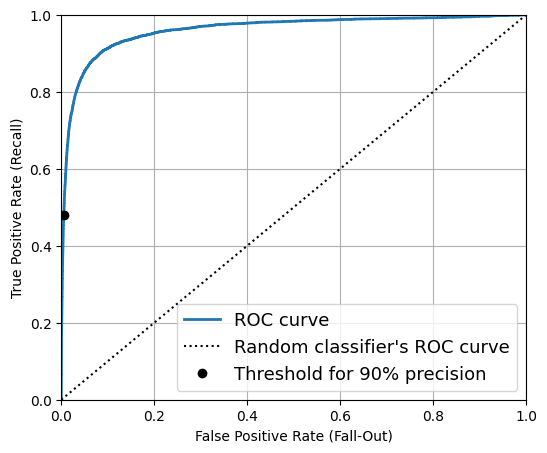

In [23]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies 

plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)


plt.show()

In [24]:
# thresholds are decreasing ordered
(thresholds <= threshold_for_90_precision) # agr max = index of threshold_for_90_precision or the first that is less

array([False, False, False, ...,  True,  True,  True])

In [25]:
(thresholds >= threshold_for_90_precision) # agr max = 0

array([ True,  True,  True, ..., False, False, False])

Once again there is a trade-off: the higher the recall (TPR), the more false
positives (FPR) the classifier produces. The dotted line represents the ROC
curve of a purely random classifier; a good classifier stays as far away from
that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve
(AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a
purely random classifier will have a ROC AUC equal to 0.5.

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [28]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [29]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

The precision_recall_curve() function expects labels and scores
for each instance, so we need to train the random forest and make it assign a
score to each instance. But the RandomForestClassifier class does
not have a decision_function() method, due to the way it works
(we will cover this in Chapter 7). Luckily, it has a predict_proba()
method which returns class probabilities for each instance, and we can just
use the probability of the positive class as a score, it will work fine

These are estimated probabilities, not actual probabilities. For example, if you look at all
the images that the model classified as positive with an estimated probability between
50% and 60%, roughly 94% of them are actually positive. So the model’s estimated
probabilities were much too low in this case—but models can be overconfident as well.

If the model predicts probabilities between 50% and 60% for certain instances, we would expect that roughly 50% to 60% of those instances are actually positive.
Observation: In this case, about 94% of the instances are actually positive when the model predicted probabilities between 50% and 60%. This indicates the model is underestimating the probabilities because the actual proportion of positives is much higher than the estimated probability range.

In [30]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [31]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

In [32]:
idx_for_50_threshold = (thresholds_forest <= 0.5).argmax()

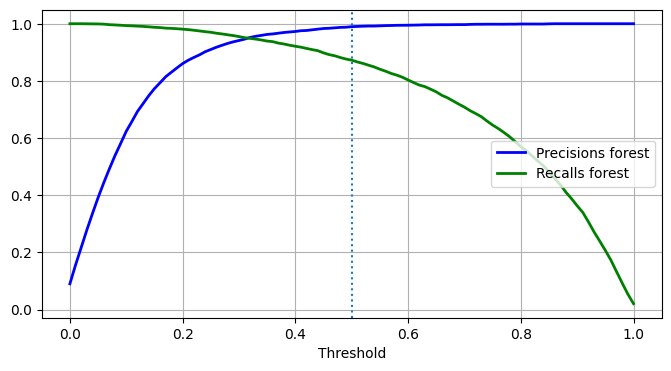

In [33]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds_forest, precisions_forest[:-1], "b-", label="Precisions forest", linewidth=2)
plt.plot(thresholds_forest,  recalls_forest[:-1], "g-", label="Recalls forest", linewidth=2)
plt.axvline(0.5, linestyle=":")


# extra code – just beautifies
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

In [34]:
fpr_forest, tpr_forest, thresholds_forest_roc = roc_curve(y_train_5, y_scores_forest)

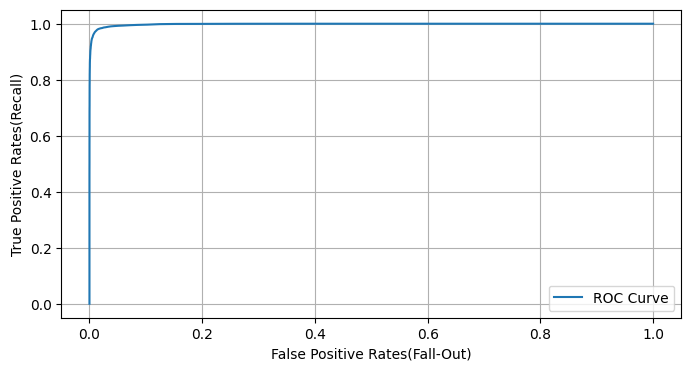

In [35]:
plt.figure(figsize=(8, 4))
plt.plot(fpr_forest, tpr_forest, label="ROC Curve")

plt.grid()
plt.xlabel("False Positive Rates(Fall-Out)")
plt.ylabel("True Positive Rates(Recall)")
plt.legend()

We could use `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` to compute `y_train_pred_forest`, but since we already have the estimated probabilities, we can just use the default threshold of 50% probability to get the same predictions much faster:

In [36]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [37]:
precision_score(y_train_5, y_train_pred_forest)


0.9897468089558485

In [38]:
recall_score(y_train_5, y_train_pred_forest)


0.8725327430363402

In [39]:
roc_auc_score(y_train_5, y_scores_forest)


0.9983436731328145

# Predict the on the test set

## SGD MODEL

In [46]:
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [49]:
y_pred_5 = sgd_clf.predict(X_test)

y_test_5 = (y_test == '5')

In [50]:
print("accuracy_score:", accuracy_score(y_test_5, y_pred_5)) 
print("precision_score:",precision_score(y_test_5, y_pred_5))
print("recall_score:",recall_score(y_test_5, y_pred_5))   
print("f1_score:",f1_score(y_test_5, y_pred_5)) 

accuracy_score: 0.9492
precision_score: 0.6618887015177066
recall_score: 0.8800448430493274
f1_score: 0.7555341674687199


# RFC

In [51]:
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(random_state=42)

In [52]:
y_pred_5 = forest_clf.predict(X_test)


In [53]:
print("accuracy_score:", accuracy_score(y_test_5, y_pred_5)) 
print("precision_score:",precision_score(y_test_5, y_pred_5))
print("recall_score:",recall_score(y_test_5, y_pred_5))   
print("f1_score:",f1_score(y_test_5, y_pred_5)) 

accuracy_score: 0.9877
precision_score: 0.993581514762516
recall_score: 0.8677130044843049
f1_score: 0.926391382405745
